In [189]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from warnings import filterwarnings
filterwarnings("ignore")

In [190]:
#İlk olarak veri okunarak,tarih dönüşümü yapılıp,index olarak ataması yapıldı. Frekansı günlük olarak ayarlandı.
df=pd.read_csv("data_-_train.csv",parse_dates=['date'],index_col="date").asfreq('D')
df

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,NaN,0.0
2022-06-14,79,11.813969,0.0


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 776 entries, 2020-05-02 to 2022-06-16
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   orders       776 non-null    int64  
 1   temperature  756 non-null    float64
 2   media_spend  776 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 24.2 KB


In [192]:
# Eksik Verilerin kontrol edilmesi
df.isnull().sum()
#Görüldüğü üzere sıcaklık verisinde 20 null değer mevcut.

orders          0
temperature    20
media_spend     0
dtype: int64

Veriyi kontrol ettikten sonra aynı işlemleri Unseen Data için de yapalım

In [193]:
#Unseen veriye de ,tarih dönüşümü ve index ataması yapılarak frekansının günlük olarak ayarlanması
unseen=pd.read_csv("data_-_unseen_features.csv",parse_dates=["date"],index_col="date").asfreq('D')
unseen

,temperature,media_spend
date,,
2022-06-17,11.923126,0.000000
2022-06-18,14.986238,0.000000
2022-06-19,11.003947,0.000000
2022-06-20,12.699259,0.000000
2022-06-21,17.852300,0.000000
2022-06-22,11.601299,0.000000
2022-06-23,16.207998,14.847883
2022-06-24,12.952067,0.000000
2022-06-25,9.284319,14.664207


In [194]:
unseen.isnull().sum()

temperature    1
media_spend    0
dtype: int64

KAYIP VERİLERİN ELE ALINMASI

In [195]:
#Data içerisindeki 20 Sıcaklık verisi interpolasyon metodu ile dolduruldu.
df["temperature"]=df["temperature"].interpolate()
df

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0
...,...,...,...
2022-06-12,76,11.472592,0.0
2022-06-13,78,11.643281,0.0
2022-06-14,79,11.813969,0.0


In [196]:
df["temperature"].isnull().sum()
#Nan Değer kalmadı

0

In [197]:
#Unseen içerisindeki eksik verinin interpolate metodu ile doldurulması
unseen["temperature"]=unseen["temperature"].interpolate()
unseen

,temperature,media_spend
date,,
2022-06-17,11.923126,0.000000
2022-06-18,14.986238,0.000000
2022-06-19,11.003947,0.000000
2022-06-20,12.699259,0.000000
2022-06-21,17.852300,0.000000
2022-06-22,11.601299,0.000000
2022-06-23,16.207998,14.847883
2022-06-24,12.952067,0.000000
2022-06-25,9.284319,14.664207


In [198]:
unseen["temperature"].isnull().sum()

0

Aykırı değerlerin(Outliers) ele alınması

<Figure size 640x480 with 0 Axes>

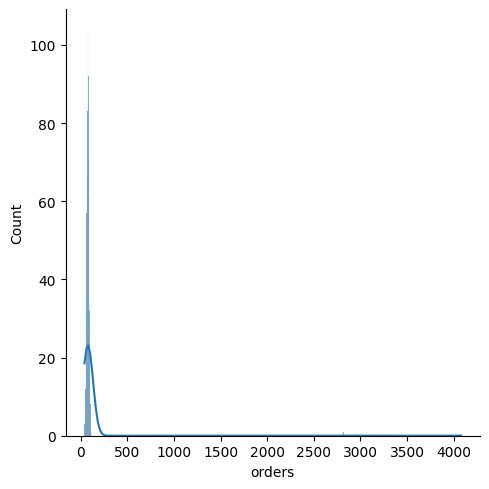

In [199]:
# Orders kolonunun kontrol edilmesi
plt.figure()
sns.displot(df["orders"],kde=True)
plt.show()

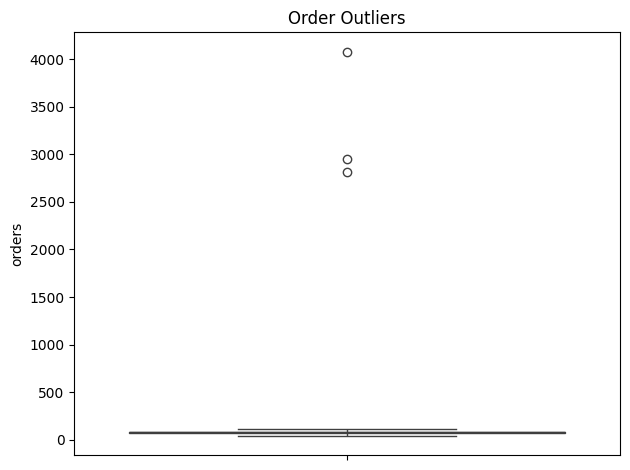

In [200]:
sns.boxplot(df["orders"])
plt.title("Order Outliers")
plt.tight_layout()
plt.show()
#Csv-2816,2952,4080

In [201]:
#Yukarıdaki dağılıma sebep olan değerleri göstermek için en büyük 3 değerin alınması
outlier_degerler=df["orders"].nlargest(5)
outlier_degerler
#İlk 3 değer ciddi anlamda normal dağılımı bozuyor.

date
2021-03-22    4080
2020-06-03    2952
2021-01-14    2816
2021-08-29     113
2021-10-27     111
Name: orders, dtype: int64

In [202]:
#Yukarıda görünen en büyük 3 değerin(Outlier Değerler) NaN olarak ayarlanması
df["orders"].loc[["2021-03-22","2020-06-03","2021-01-14"]]=np.NaN
#NaN ile doldurulan veriyi görüntüleme
df.loc[["2021-03-22","2020-06-03","2021-01-14"]]

,orders,temperature,media_spend
date,,,
2021-03-22,NaN,20.155265,0.0
2020-06-03,NaN,9.493584,0.0
2021-01-14,NaN,-4.468595,0.0


In [203]:
#NaN ile doldurulan Outlier değerlerin İnterpolasyon Metodu ile doldurulması 
df["orders"]=df["orders"].interpolate()

In [204]:
# BASKILAMA YÖNTEMİ NE KADAR İYİ BİR YÖNTEM DE OLSA, OUTLIER DEĞERLERİN İLK OLARAK NAN İLE DOLDURULARAK İNTERPOLASYON UYGULANMASI İLE MODEL DAHA İYİ SONUÇ VERMEKTEDİR.

# # Order sütununda görünen 3 outlier değerin baskılanması
# for  col in df:
#     Q1=df["orders"].quantile(0.25)
#     Q3=df["orders"].quantile(0.75)
#     IQR=Q3-Q1
#     lower=Q1-(IQR*1.5)
#     upper=Q3+(IQR*1.5)
#     df["orders"]=np.where(df["orders"]>upper,upper,np.where(df["orders"]<lower,lower,df['orders']))
# plt.figure()
# sns.displot(df["orders"],kde=True)
# plt.show()
# #Bir önceki grafiğe göre daha normal bir dağılım göstermektedir.

<Figure size 640x480 with 0 Axes>

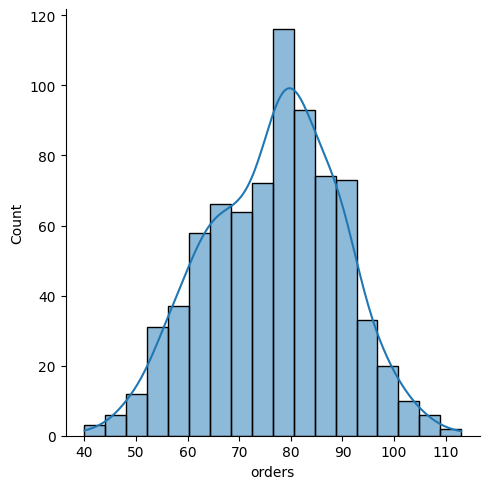

In [205]:
plt.figure()
sns.displot(df["orders"],kde=True)
plt.show()

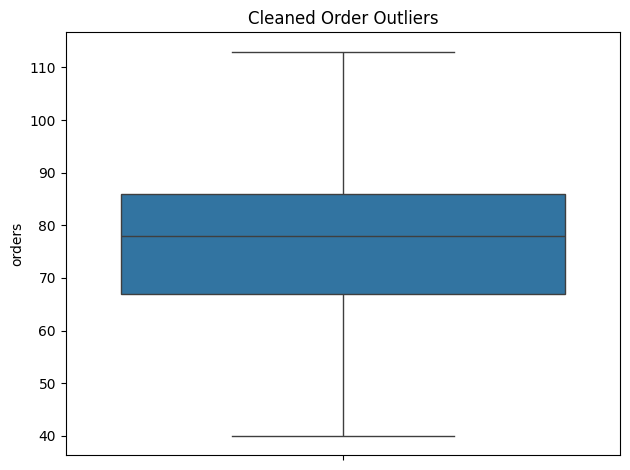

In [206]:
# Baskılanan Orders outlier değerlerinin boxplot grafiği yeniden kontrolü
sns.boxplot(df["orders"])
plt.title("Cleaned Order Outliers")
plt.tight_layout()
plt.show()


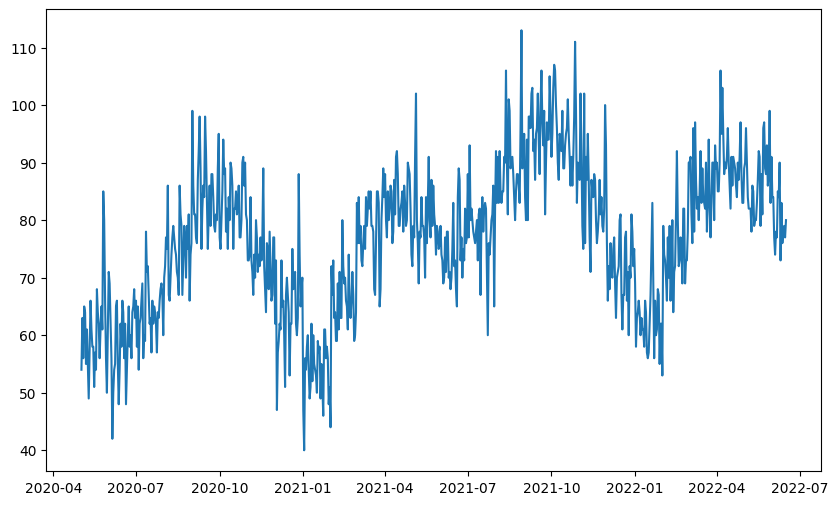

In [207]:
#Order sütunu grafiğinin çizilmesi
plt.figure(figsize=(10,6))
plt.plot(df["orders"])

<Figure size 800x800 with 0 Axes>

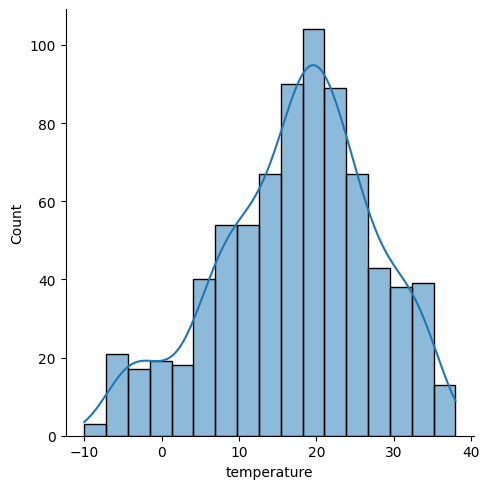

In [208]:
# -TEMPERATURE

plt.figure(figsize=(8,8))
sns.displot(df["temperature"],kde=True)
plt.show()
#Sıcaklık değerleri normal dağılıma sahip

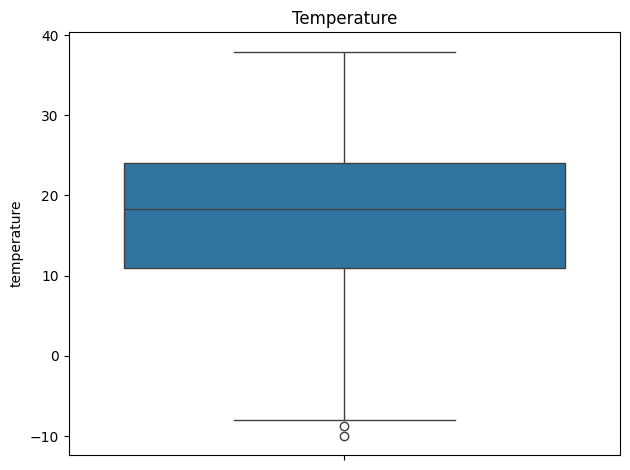

In [209]:
# Normal dağılıma sahip gibi görünse de boxplot grafiği ile tekrar ele alalım.
sns.boxplot(df["temperature"])
plt.title("Temperature")
plt.tight_layout()
plt.show()

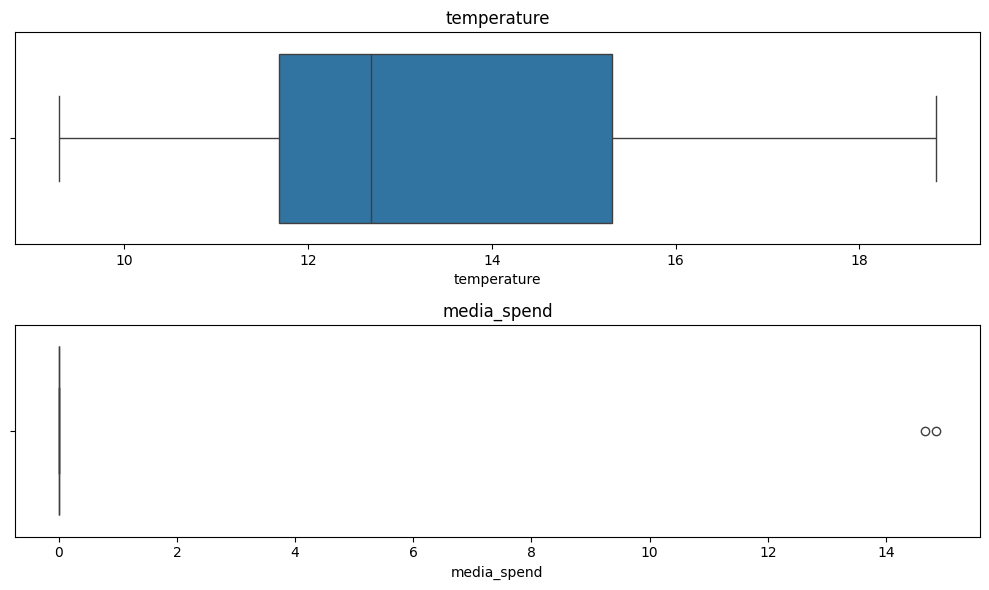

In [210]:
#Unseen Datanın İncelenmesi

fig, axs = plt.subplots(len(unseen.columns), figsize=(10,6))

for i, col in enumerate(unseen.columns):
    sns.boxplot(x=unseen[col], ax=axs[i])
    axs[i].set_title(col)

# Adjust subplot layout
plt.tight_layout()
plt.show()
#Unseen data içerisinde outlier değer görünmemekte

In [211]:
# Target kolonu ile diğer kolonlar arasındaki korelasyonun gösterilmesi
df_corr=df[["orders","temperature","media_spend"]].corr(method='spearman')
df_corr
#Veriler ilk izlenimler sonucu normal dağıldığı için spearman kullanıldı.

,orders,temperature,media_spend
orders,1.000000,0.729103,0.201471
temperature,0.729103,1.000000,0.014029
media_spend,0.201471,0.014029,1.000000


In [212]:
# df_corr=df[["orders","temperature","media_spend"]].corr(method='pearson')
# print(df_corr)
      
# df_corr=df[["orders","temperature","media_spend"]].corr(method='kendall')
# print(df_corr)

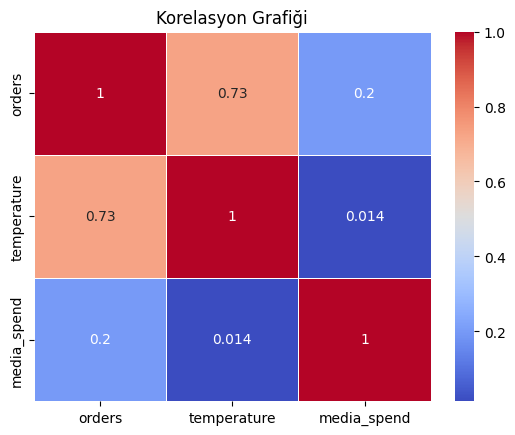

In [213]:
sns.heatmap(df_corr,annot=True,cmap="coolwarm",linewidths=.5)
plt.title("Korelasyon Grafiği")
plt.show()
# Grafikten anlaşılacağı üzere Order(sipariş sayısının) temperature ve media_spend ile bir ilgisi olduğu görünmektedir.

In [214]:
# Verinin Durağanlığının ölçülmesi
from statsmodels.tsa.stattools import adfuller
adf_test=adfuller(df["orders"])
p_value=adf_test[1]
p_value
#Sonuca bakacak olursak p_value>0.05 old. için veri durağan değildir.

0.1094248624717199

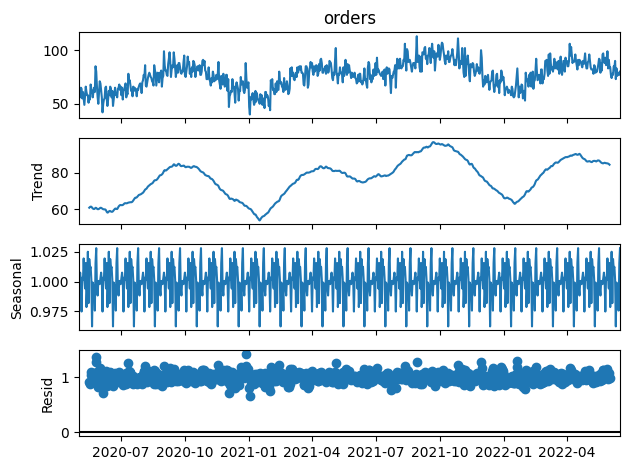

In [215]:
#Seasonal Decompose grafiğinin çizilerek verinin trend ve mevsimsellik gibi özelliklerinin incelenmesi
from statsmodels.tsa.seasonal import seasonal_decompose
df_dec = seasonal_decompose(df["orders"], model="mull", period=30).plot()


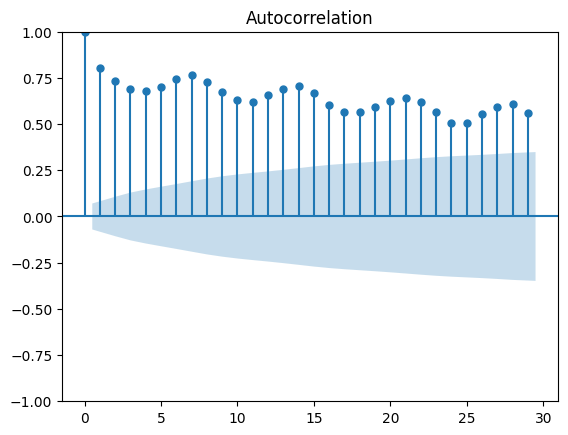

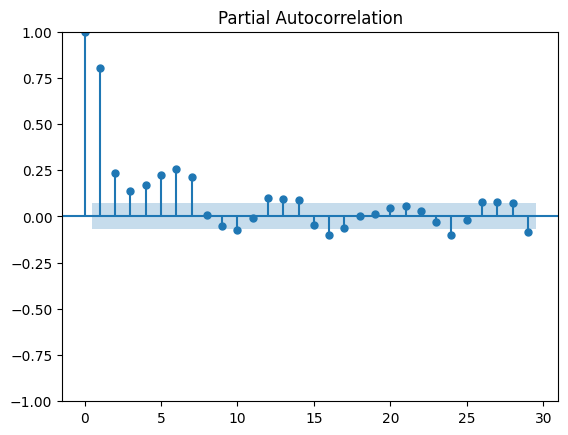

In [216]:
# Orders Sütununa ait ACF ve PACF Grafiklerinin Çizdirilmesi
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["orders"])

plot_pacf(df["orders"])
plt.show()
#Acf grafiğinde bir mevsimsellik ve trend var denilebilir.

In [217]:
#Verinin durağanlığının test edilmesi
adf_test=adfuller(df["orders"])
p_value=adf_test[1]
p_value

0.1094248624717199

In [218]:
#Durağan hale getirmek için diff işlemi yapıldı. Verinin orijinali 1 kere fark alınınca durağan hale geldi.
df1=df.copy()
df1["orders"]=df1["orders"].diff()
df1=df1.dropna()

In [219]:
adf_test=adfuller(df1["orders"])
p_value=adf_test[1]
p_value
#Veri durağan hale getirildi.

1.0537205601128536e-14

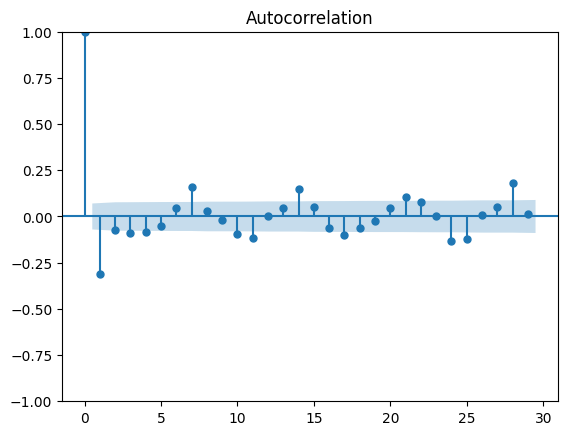

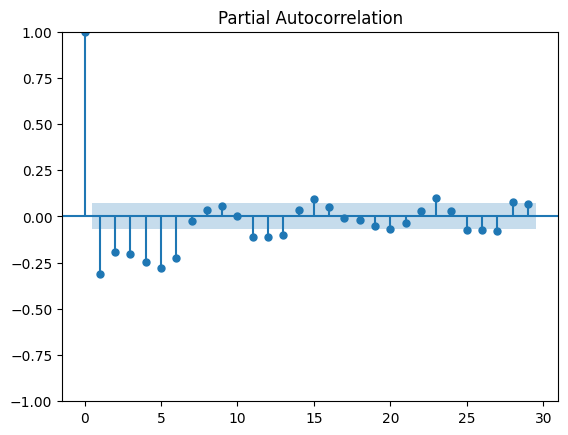

In [220]:
# Durağan hale getirdikten sonra ACF ve PACF Grafiklerinin Yeniden İncelenmesi

plot_acf(df1["orders"])

plot_pacf(df1["orders"])
plt.show()
#Acf grafiği daha normal bir hal aldı

In [221]:
#Modele exog olarak verilecek değerlerin durağanlığının kontrol edilmesi
adf_test = adfuller(df["temperature"])
p_value = adf_test[1]
print(p_value)
adf_test = adfuller(df["media_spend"])
p_value = adf_test[1]
print(p_value)
#Temperature değerinin durağan olmadığı, media_spend kolonunun ise durağan olduğu gözlenmektedir.

0.13178731632527196
0.0


In [222]:
# Exog olarak verilecek sıcaklık değeri fark alınarak durağan hale getirildi.(Daha normal bir sonuç için)
df["temperature"]=df["temperature"].diff()
df=df.dropna()


In [223]:
df["temperature"].isnull().sum()
#Diff aldıktan sonra oluşacak null değerin atılması

0

In [224]:
#Exog olarak verilecek temperature değeri durağan hale getirildi.
adf_test = adfuller(df["temperature"])
p_value = adf_test[1]
print(p_value)
#Exog olarak verilecek temperature değeri durağan hale getirildi.

0.0


In [225]:
#Verinin Train ve Test Olarak Bölünmesi
data_train=df[:-14]
data_test=df[-14:]
print(len(data_train),"Training Set")
print(len(data_test),"Test Set")


761 Training Set
14 Test Set


In [226]:

data_test


,orders,temperature,media_spend
date,,,
2022-06-03,77.0,1.166438,0.0
2022-06-04,74.0,-5.463650,0.0
2022-06-05,78.0,3.769344,0.0
2022-06-06,77.0,1.758233,0.0
2022-06-07,85.0,-5.022199,0.0
2022-06-08,84.0,2.361692,0.0
2022-06-09,90.0,7.803964,0.0
2022-06-10,73.0,-8.792055,0.0
2022-06-11,83.0,9.441176,0.0


In [227]:
# # MODELİN EN İYİ PARAMETRESİNİ BULMAK İÇİN (MANUEL GRID SEARCH YERİNE)

# import optuna
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import itertools
# import pandas as pd
# import logging

# optuna.logging.set_verbosity(optuna.logging.ERROR)


# p = d = q = range(0, 4)
# pdq = list(itertools.product(p, d, q))
# pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))] 

# order_aic_bic = []
# def objective_sarima(trial):
#     order = trial.suggest_categorical('order', pdq)
#     seasonal_order = trial.suggest_categorical('seasonal_order', pdqs)
#     trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct', None])
#     model = SARIMAX(data_train["orders"], exog=data_train[["temperature","media_spend"]], order=order, seasonal_order=seasonal_order, trend=trend, initialization='approximate_diffuse')
#     mdl = model.fit(disp=0)
#     aic = mdl.aic
#     bic = mdl.bic
#     order_aic_bic.append((order, seasonal_order, trend, aic, bic))

# study = optuna.create_study(direction="minimize")
# study.optimize(objective_sarima, n_trials=50)

# order_df = pd.DataFrame(order_aic_bic, columns=["order", "seasonal_order", "trend", "AIC", "BIC"])
# print(order_df.sort_values("AIC").head(3))
# print(order_df.sort_values("BIC").head(3))

In [228]:
#Model sonucu elde edilen en iyi değerlerin oluşturulacak modele verilmesi
# Modeli oluştur
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data_train["orders"], order=(2,1,3), seasonal_order=(1, 0,0, 7) , trend=None,exog=data_train[["temperature","media_spend"]]) #??

# Modeli eğit              
model_fit = model.fit(disp=0)

# Tahminleri yap
fitted = model_fit.predict()

# Fit edilen modelin hata payı
resids = model_fit.resid

# Tahminlerin traine eklenmesi

data_train.loc[:,"fitted"] = fitted

In [229]:
#Oluşturulan modeli inceleme
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             orders   No. Observations:                  761
Model:             SARIMAX(2, 1, 3)x(1, 0, [], 7)   Log Likelihood               -2275.795
Date:                            Sun, 11 Feb 2024   AIC                           4569.589
Time:                                    00:04:17   BIC                           4611.289
Sample:                                05-03-2020   HQIC                          4585.647
                                     - 06-02-2022                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature     0.5224      0.030     17.548      0.000       0.464       0.581
media_spend     1.0332      0.05

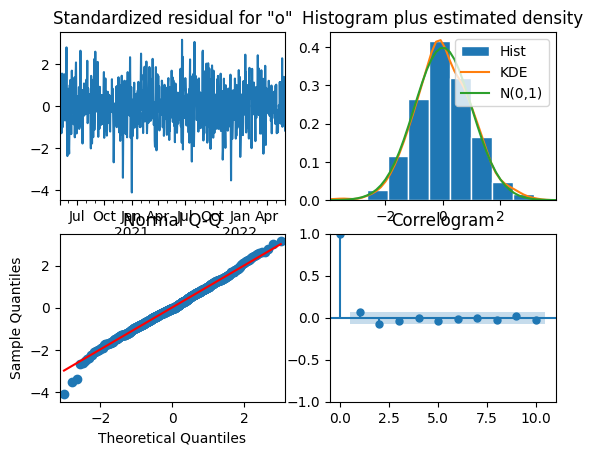

In [230]:
# SARIMAX ile elde edilen modelin görselleştirilmesi
model_fit.plot_diagnostics()

plt.show()

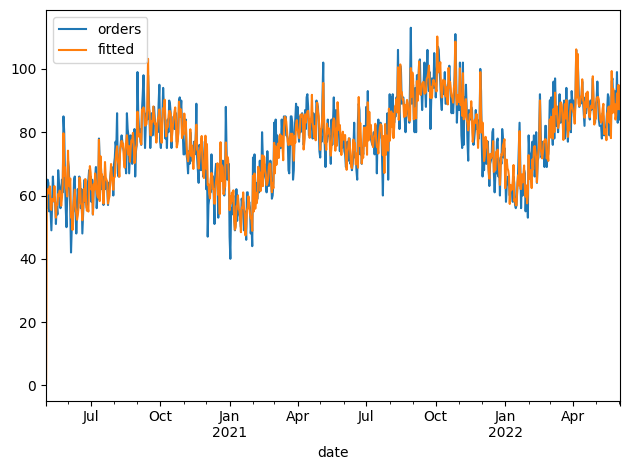

In [231]:
# Orders ile Fit edilen tahminlerin çizdirilmesi
data_train[["orders","fitted"]].plot()
plt.tight_layout()
plt.show()

In [239]:
df["temperature"].loc['2022-06-03':'2022-06-10']

date
2022-06-03    1.166438
2022-06-04   -5.463650
2022-06-05    3.769344
2022-06-06    1.758233
2022-06-07   -5.022199
2022-06-08    2.361692
2022-06-09    7.803964
2022-06-10   -8.792055
Freq: D, Name: temperature, dtype: float64

In [233]:
test_predicted = model_fit.forecast(steps=len(data_test), exog=df[["temperature","media_spend"]][data_test.index])


KeyError: "None of [DatetimeIndex(['2022-06-03', '2022-06-04', '2022-06-05', '2022-06-06',\n               '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',\n               '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14',\n               '2022-06-15', '2022-06-16'],\n              dtype='datetime64[ns]', name='date', freq='D')] are in the [columns]"